# CNNs avec Keras sur des données de paysage

## Vérification de l'utilisation de GPU

Allez dans le menu `Exécution > Modifier le type d'execution` et vérifiez que l'on est bien en Python 3 et que l'accélérateur matériel est configuré sur « GPU ».

In [1]:
!nvidia-smi

/bin/sh: 1: nvidia-smi: not found


## Import des librairies nécessaires

In [17]:
import itertools
import os
import pathlib
import random
import typing

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import sklearn.utils
import sklearn.metrics
import tensorflow as tf
import keras

## Préparation des données

Pour charger nos données, nous allons combiner plusieurs libraires : [OpenCV](https://opencv.org/), [NumPy](https://numpy.org/) et [scikit-learn](https://scikit-learn.org/stable/). Ces librairies seront appelées depuis la fonction `get_images`.

Après avoir chargé chaque image, nous allons passer leur canaux en RGB puis les redimensionner à 150x150, enfin, par défaut, nous retournerons un dataset mélangé grâce à [`sklearn.utils.shuffle`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html).

*Complétez la fonction `get_images` qui va chercher les images dans `dir_path` contenant un dossier par classe. Chaque dossier de classe contient l'ensemble des images de cette classe. Il vous faut attribuer le label correct à chaque image.*

In [11]:
label_names = ["convolvulaceae","monimiaceae","amborella","castanea","desmodium","eugenia",
              "laurus","litsea","magnolia","rubus","ulmus"]

def get_images(filename):

  df=pd.read_csv(filename)
  images = []
  labels = []

  for i in range(len(df["label"])):
    path=df["img_path"][i]

    image=cv2.imread(path)
    image=cv2.resize(image,(150,150))
    images.append(image)

    label=df["label"][i]
    labels.append(label)

  return images,labels

label_to_index = {l: i for i, l in enumerate(label_names)}

## Appel à `get_images`

In [25]:
images, labels= get_images("data_train_labeled.csv")

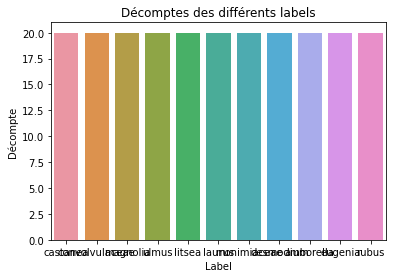

In [5]:

seaborn.countplot(x=labels)
plt.title("Décomptes des différents labels")
plt.ylabel("Décompte")
plt.xlabel("Label")
plt.show()

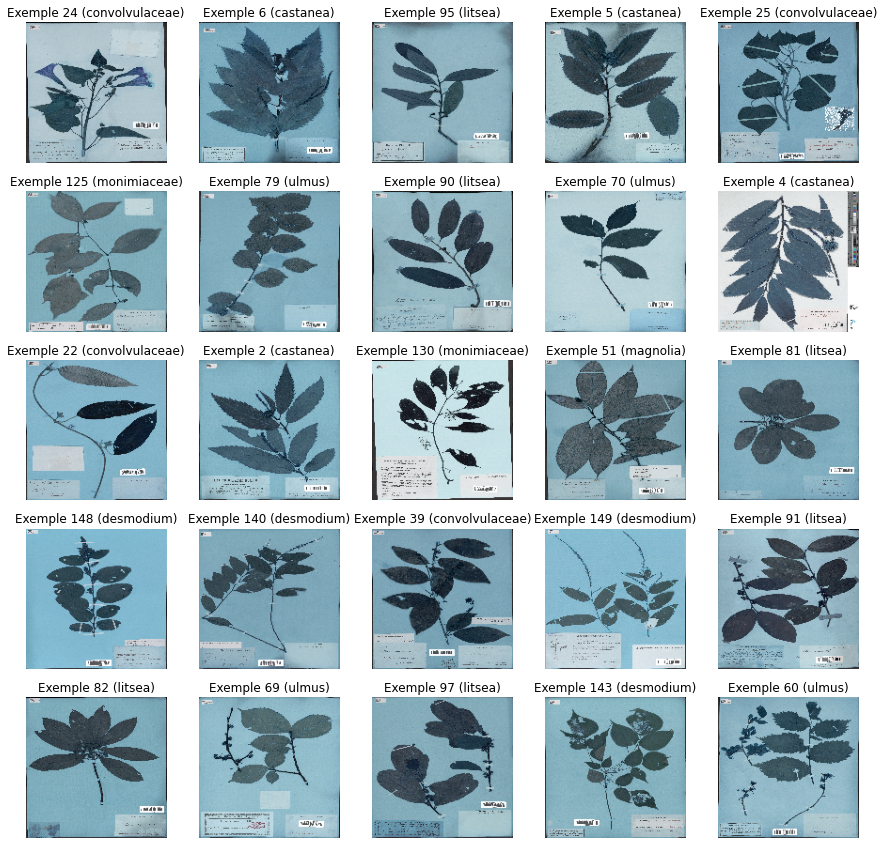

In [26]:
# Création de la grille de sous-plots. On donne l'argument figsize pour agrandir
# la taille de la figure qui est petite par défaut
f, ax = plt.subplots(5, 5, figsize=(15, 15))

# On choisit 25 indices au hasard, sans replacement (on ne veut pas afficher la
# même image deux fois)
random_indexes = np.random.choice(images[0].shape[0],
                                     size=(5, 5),
                                     replace=False)

for i in range(5):
  for j in range(5):
    img_index = random_indexes[i, j]
    image = images[img_index]
    label = labels[img_index]

    # Affichage avec matplotlib et sa fonction imshow, très pratique en vision par
    # ordinateur
    ax[i, j].imshow(image)
    ax[i, j].set_title(f"Exemple {img_index} ({label})")
    ax[i, j].axis('off')

## Apprentissage

### Modèle 1 (Simple)

In [39]:
images=np.array(images)
labels=np.array(labels)

labels_int=[label_names.index(x) for x in labels]
labels_int=np.array(labels_int)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 148, 148, 15)      420       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 49, 49, 15)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 36015)             0         
                                                                 
 dense_13 (Dense)            (None, 11)                396176    
                                                                 
Total params: 396,596
Trainable params: 396,596
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
5/5 [==============================] - 2s 248ms/step - loss: 194.2715 - acc: 0.1039 - val_loss: 505.93

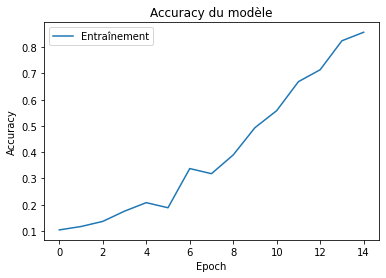

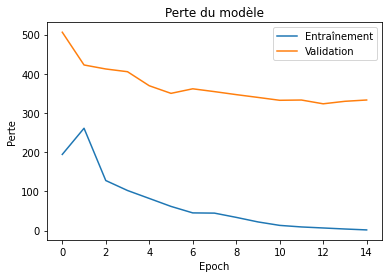

In [40]:
# Vos améliorations ici
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(15,
                              kernel_size=(3, 3),
                              activation="relu",
                              input_shape=(150, 150, 3)))
model.add(keras.layers.MaxPool2D(3,3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(11, activation="softmax"))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

# Affichage d'un résumé du modèle
model.summary()



# Apprentissage du modèle
training = model.fit(images, labels_int, epochs=15, validation_split=0.30)


# Plot des métriques d'entraînement
def plot_metrics(history) -> None:
  plt.plot(training.history["acc"])
  #plt.plot(training.history["val_accuracy"])
  plt.title("Accuracy du modèle")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper left")
  plt.show()

  plt.plot(training.history["loss"])
  plt.plot(training.history["val_loss"])
  plt.title("Perte du modèle")
  plt.ylabel("Perte")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper right")
  plt.show()


plot_metrics(training.history)

### Modèle 2 (Complexe)

In [42]:
conv2d_params = dict(kernel_size=(3,3),
                     activation="relu",
                     kernel_initializer="orthogonal",
                     padding="same")

dense_params = dict(activation="relu", kernel_initializer="orthogonal")

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(200, input_shape=(150, 150, 3), **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(200, **dense_params))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(100, **dense_params))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(50, **dense_params))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(11,
                             activation="softmax",
                             kernel_initializer="orthogonal"))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Affichage d'un résumé du modèle
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 150, 150, 200)     5600      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 75, 75, 200)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 75, 75, 200)       360200    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 38, 38, 200)      0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 38, 38, 200)       360200    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 19, 19, 200)    

In [ ]:
# Apprentissage du modèle
training_2 = model.fit(images,
                     labels_int,
                     epochs=15,
                     validation_split=0.30,
                     batch_size=128)

# Visualisation des métriques d'entrainement
plot_metrics(training_2.history)

## Évaluation des performances sur l'ensemble de test

Dans le dossier `seg_test` se trouve un ensemble de données qui n'ont jamais été vues durant l'apprentissage.

On utilisera la méthode `evaluate(X, y)` du modèle pour évaluer la qualité de nos prédictions sur ce dataset.

In [ ]:
test_images,test_labels, test_file_paths = get_images(
    pathlib.Path("dataset-landscape") / "seg_test")
model.evaluate(test_images, test_labels, verbose=1)

## Analyse d'erreur

On affiche la matrice de confusion puis on regarde des images mal classées.

In [ ]:
def analyze_preds(preds, labels):
  confusion_matrix = sklearn.metrics.confusion_matrix(preds,
                                                      labels,
                                                      normalize="true")
  seaborn.heatmap(confusion_matrix,
                  cmap="rocket_r",
                  xticklabels=label_names,
                  yticklabels=label_names)
  plt.title("Matrice de confusion")
  plt.show()

  seaborn.countplot(x=list(map(lambda x: label_names[x], preds)))
  plt.title("Décomptes des classes prédites")
  plt.ylabel("Décompte")
  plt.xlabel("Class")
  plt.show()


test_pred = numpy.argmax(model.predict(test_images), axis=-1)
analyze_preds(test_pred, test_labels)

In [ ]:
def plot_mistakes(predicted_class: str, true_class: str) -> None:
  print(f"Prédiction : {predicted_class}, classe réelle : {true_class}")
  mistakes = test_images[(test_pred == label_to_index[predicted_class])
                         & (test_labels == label_to_index[true_class])]
  random_indexes = numpy.random.choice(mistakes.shape[0],
                                       size=min(mistakes.shape[0], 25),
                                       replace=False)
  grid_indexes = itertools.product(range(5), repeat=2)

  _, ax = plt.subplots(5, 5, figsize=(15, 15))
  for img_index, (i, j) in zip(random_indexes, grid_indexes):
    ax[i, j].imshow(mistakes[img_index])
    ax[i, j].axis("off")
  plt.show()

In [ ]:
# Plot les images prédites glacier alors qu'elles ont un label montagne
plot_mistakes("glacier", "mountain")

In [ ]:
# Plot les images prédites glacier alors qu'elles ont un label mer
plot_mistakes("glacier", "sea")

In [ ]:
# Plot les images prédites bâtiment alors qu'elles ont un label mer
plot_mistakes("buildings", "sea")

## Transfert d'apprentissage

In [ ]:
base_model = keras.applications.EfficientNetB7(include_top=False,
                                               weights="imagenet",
                                               input_shape=(150, 150, 3))

base_model.trainable = False

model = keras.Sequential(
    [base_model,
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Conv2D(1024, 1, activation="relu"),
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Conv2D(256, 1, activation="relu"),
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Conv2D(64, 1, activation="relu"),
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Conv2D(16, 1, activation="relu"),
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Flatten(),
     keras.layers.Dense(6, activation="softmax", kernel_regularizer="l2")])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

In [ ]:
training = model.fit(images,
                     labels,
                     epochs=5,
                     validation_split=0.30,
                     batch_size=512)

plot_metrics(training.history)

In [ ]:
model.evaluate(test_images, test_labels, verbose=1)
test_preds = numpy.argmax(model.predict(test_images), axis=-1)
analyze_preds(test_preds, test_labels)
plot_mistakes("glacier", "mountain")
plot_mistakes("glacier", "sea")
plot_mistakes("buildings", "sea")

## Prédire dans des condition « réelles »

Dans le dossier `seg_pred` se trouvent des images non-annotées. On ne peut donc pas évaluer correctement les performances sur cet ensemble. 

Cependant, on peut afficher des photos et les probabilités que notre modèle attribue à chaque classe.

In [ ]:
pred_images, _, pred_file_paths = get_images(
    pathlib.Path("dataset-landscape") / "seg_pred")
pred_images.shape

In [ ]:
# Création de la grille de sous-plots. On donne l'argument figsize pour agrandir
# la taille de la figure qui est petite par défaut
_, ax = plt.subplots(10, 5, figsize=(30, 45))

# On choisit 25 indices au hasard, sans replacement (on ne veut pas afficher la
# même image deux fois)
random_indexes = numpy.random.choice(pred_images.shape[0],
                                     size=(5, 5),
                                     replace=False)

for i in range(5):
  for j in range(5):
    img_index = random_indexes[i, j]
    # Récupération de l'image et prédiction de sa classe
    image = pred_images[img_index]
    probabilities = model.predict(image[None, ...])[0]
    predicted_class = label_names[numpy.argmax(probabilities)]

    # Affichage avec matplotlib et sa fonction imshow, très pratique en vision
    # par ordinateur
    ax[i * 2, j].imshow(image)
    ax[i * 2, j].set_title(f"Exemple {img_index}")
    ax[i * 2, j].axis('off')

    # Affichage de la distribution de prédiction sur la ligne d'en dessous
    ax[i * 2 + 1, j].bar(label_names, probabilities)